In [1]:
import pickle
import os
import smart_open
import numpy as np
import random
import torch
import itertools
from tqdm import tqdm
from coatiLDM.common.utils import utc_epoch_now
import rdkit
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from coatiLDM.constants import FIGURE_DATA_PATH
from coatiLDM.common.s3 import load_figure_file

In [2]:
figure_path = './figure_data/partial_diffusion_data/'


In [4]:
uncond = load_figure_file('uncondnearby_results_dict.pkl', figure_path,filetype='pkl')
logp_cg = load_figure_file('logp_cg_results_dict.pkl', figure_path ,filetype='pkl')
hcaii_cg = load_figure_file('hcaii_cg_results_dict.pkl', figure_path ,filetype='pkl')
logp_cfg = load_figure_file('logp_cfg_results_dict.pkl', figure_path ,filetype='pkl')
hcaii_cfg = load_figure_file('hcaii_cfg_results_dict.pkl', figure_path ,filetype='pkl')


In [4]:
cg_weights = [10,20,50,100]
cfg_weights = [.1,.3]
steps=  [0,5,10,50,75,100,200,300]
lp_tani_cfg = logp_cfg['tanimoto']
lp_cfg = logp_cfg['logp']
lp_tani_cg = logp_cg['tanimoto']
lp_cg = logp_cg['logp']

is_tani_cfg = hcaii_cfg['tanimoto']
is_cfg = hcaii_cfg['invsig']
is_tani_cg = hcaii_cg['tanimoto']
is_cg = hcaii_cg['invsig']

tani_uncond = uncond['tanimoto']
lp_uncond = uncond['logp']
is_uncond = uncond['invsig']

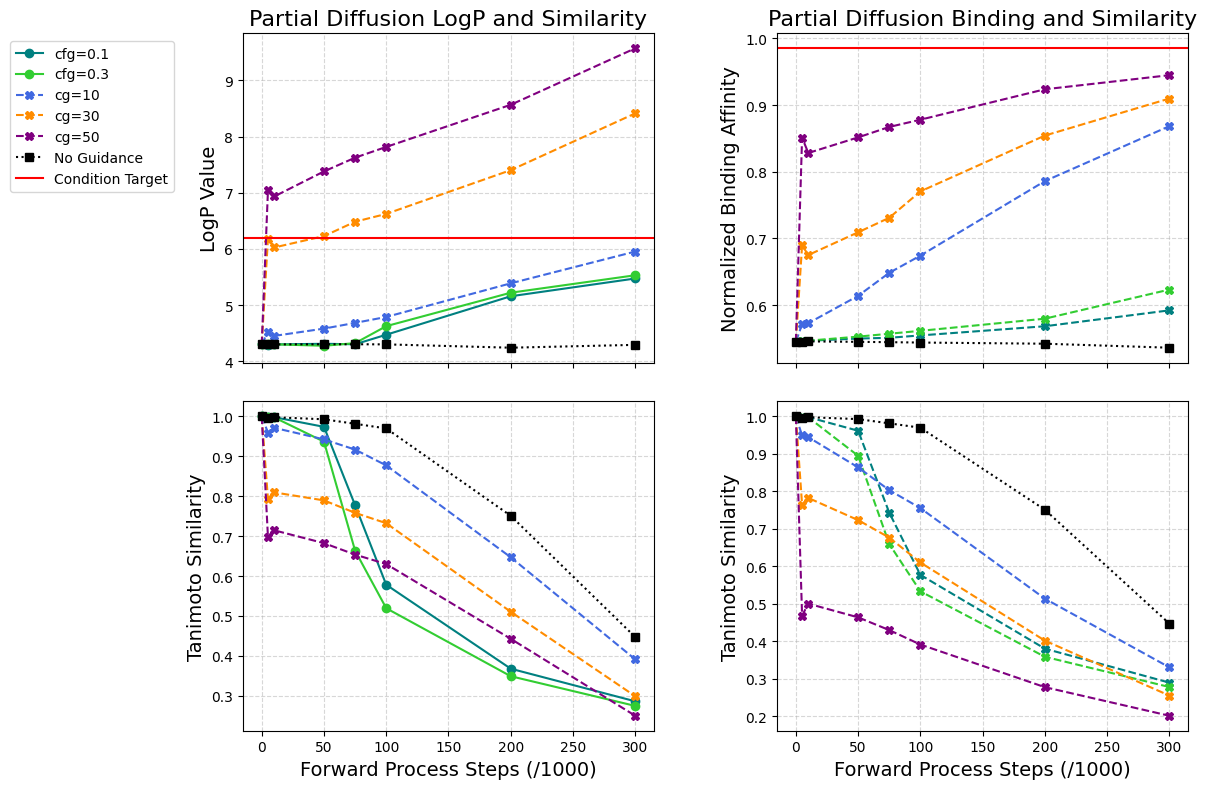

In [5]:
import matplotlib.pyplot as plt

# Data and parameters
cfg_weights = [0.1, 0.3]
cg_weights = [10, 30, 50]
steps = [0, 5, 10, 50, 75, 100, 200, 300]

# Color palette
cfg_colors = ['teal', 'limegreen']
cg_colors = ['royalblue', 'darkorange', 'purple', 'brown']
uncond_color = 'black'

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# First plot (upper left): Average LogP Values
for weight, color in zip(cfg_weights, cfg_colors):
    axes[0, 0].plot(steps, lp_cfg[weight][0], label='cfg=' + str(weight), marker='o', color=color)
for weight, color in zip(cg_weights, cg_colors):
    axes[0, 0].plot(steps, lp_cg[weight][0], label='cg=' + str(weight), linestyle='--', marker='X', color=color)
axes[0,0].plot(steps, lp_uncond['uncond'][0], label='No Guidance',color=uncond_color,linestyle=':', marker='s')
axes[0, 0].set_title('Partial Diffusion LogP and Similarity', fontsize=16)
# axes[0, 0].set_xlabel('Steps', fontsize=14)
axes[0, 0].set_ylabel('LogP Value', fontsize=14)
axes[0, 0].grid(True, linestyle='--', alpha=0.5)
axes[0, 0].axhline(y=6.2, color='red', linestyle='-', label='Condition Target')
axes[0, 0].legend()

# Second plot (upper right): Average Predicted Binding Affinity
for weight, color in zip(cfg_weights, cfg_colors):
    axes[0, 1].plot(steps, is_cfg[weight][0], label='cfg=' + str(weight), linestyle='--', marker='X', color=color)
for weight, color in zip(cg_weights, cg_colors):
    axes[0, 1].plot(steps, is_cg[weight][0], label='cg=' + str(weight), linestyle='--', marker='X', color=color)
axes[0,1].plot(steps, is_uncond['uncond'][0], label='No Guidance',color=uncond_color,linestyle=':', marker='s')
axes[0, 1].set_title('Partial Diffusion Binding and Similarity', fontsize=16)
# axes[0, 1].set_xlabel('Steps', fontsize=14)
axes[0, 1].set_ylabel('Normalized Binding Affinity', fontsize=14)
axes[0, 1].grid(True, linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=0.985, color='red', linestyle='-', label='Condition Target')
axes[0, 1].legend()

# Third plot (lower left): First version of Average Tanimoto Similarity to Starting Molecule
for weight, color in zip(cfg_weights, cfg_colors):
    axes[1, 0].plot(steps, lp_tani_cfg[weight], label='cfg=' + str(weight), marker='o', color=color)
for weight, color in zip(cg_weights, cg_colors):
    axes[1, 0].plot(steps, lp_tani_cg[weight], label='cg=' + str(weight), linestyle='--', marker='X', color=color)
axes[1,0].plot(steps, tani_uncond['uncond'], label='No Guidance',color=uncond_color,linestyle=':', marker='s')
#axes[1, 0].set_title('Average Tanimoto Similarity to Starting Molecule', fontsize=16)
axes[1, 0].set_xlabel('Forward Process Steps (/1000)', fontsize=14)
axes[1, 0].set_ylabel('Tanimoto Similarity', fontsize=14)
axes[1, 0].grid(True, linestyle='--', alpha=0.5)
#axes[1, 0].legend()

# Fourth plot (lower right): Second version of Average Tanimoto Similarity to Starting Molecule
for weight, color in zip(cfg_weights, cfg_colors):
    axes[1, 1].plot(steps, is_tani_cfg[weight], label='cfg=' + str(weight), linestyle='--', marker='X', color=color)
for weight, color in zip(cg_weights, cg_colors):
    axes[1, 1].plot(steps, is_tani_cg[weight], label='cg=' + str(weight), linestyle='--', marker='X', color=color)
axes[1,1].plot(steps, tani_uncond['uncond'], label='No Guidance',color=uncond_color, linestyle=':', marker='s')
#axes[1, 1].set_title('Average Tanimoto Similarity to Starting Molecule', fontsize=16)
axes[1, 1].set_xlabel('Forward Process Steps (/1000)', fontsize=14)
axes[1, 1].set_ylabel('Tanimoto Similarity', fontsize=14)
axes[1, 1].grid(True, linestyle='--', alpha=0.5)
#axes[1, 1].legend()

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, left=0.2)  # Adjust 'left' as needed to create space for the legend

# Create handles and labels for the legend
handles, labels = [], []
for ax in axes.flat:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)

# Place a single legend to the left of the plot
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0, 0.95))

# Remove legends from individual subplots
for ax in axes.flat:
    ax.legend().set_visible(False)

axes[0, 0].set_xticklabels([])
axes[0, 1].set_xticklabels([])


#plt.savefig('nearby_fig.svg')
# Display the plot
plt.show()
